# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Project Scope:

The scope of this project consists of the following:
1. Reading the Starbucks datasets
2. Understand the Startbucks datasets to know what cleaning needs to be done
3. Clean the data
4. Analyze the data. For this analysis we want to determine which customers have a higher conversion rate when an offer is presented, along with total non offer transactions. We will be looking at customer breakdowns by age, gender, member year, and income. This will allow us to better understand which customers we should be sending offers to and those who we should not

## Read and clean the data:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import sqlite3
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


Split channels list into seperate columns

In [4]:
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [5]:
portfolio = portfolio.drop(['channels', 'reward'], axis=1)
portfolio['duration'] = portfolio['duration'] * 24
portfolio = portfolio.rename(columns={"duration": "offer_duration_time", "difficulty": "offer_difficulty_amount"})
portfolio

,offer_difficulty_amount,offer_duration_time,id,offer_type,email,mobile,web,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1,1,0,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,1,1,1,0


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Make became_member_on column into data format

In [8]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile['id'].duplicated().sum()

0

In [11]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [12]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [13]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

Remove people with an age of 118 since it is not realistic

In [14]:
profile['age'] = profile['age'].replace(118, np.nan)

In [15]:
profile['age'][profile['age'] == 118].sum()

0.0

In [16]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Get offer id, reward amount and transaction amount from the value column

In [19]:
transcript['offer'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['offer_2'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['reward_amount'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['transaction_amount'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript.drop(['value'], axis=1, inplace=True)
transcript.head()

,event,person,time,offer,offer_2,reward_amount,transaction_amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,None,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,None,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN,NaN


In [20]:
transcript['offer'] = np.where(transcript['offer'].isnull(), transcript['offer_2'], transcript['offer'])
transcript = transcript.drop(['offer_2'],axis=1)

In [21]:
transcript.duplicated().sum()

397

In [22]:
transcript = transcript[transcript.duplicated(subset=None, keep='first') == False]
transcript.duplicated().sum()

0

In [23]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [24]:
transcript['time'].unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [25]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

Create indicator columns for when and offer is received, viewed, completed and when a transation happens (with or without offer)

In [26]:
transcript['offer_received'] = transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['transaction'] = transcript['event'].apply(lambda x: 1 if x == 'transaction' else 0)

In [27]:
transcript.head()

,event,person,time,offer,reward_amount,transaction_amount,offer_received,offer_viewed,offer_completed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,1,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,1,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,1,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1,0,0,0


Create seperate dataframs for when offers received, viewed, completed, and transactions. The level of these dataframes will be the person and offer level. The end result will be joining these dataframes back together on this level. The reason being is then we can tell what the person did when a particular offer was received

In [28]:
transcript_offer_received = transcript.query('event == "offer received"')
transcript_offer_received = transcript_offer_received[['person', 'offer', 'time', 'offer_received']]

In [29]:
transcript_offer_received = transcript_offer_received.rename(columns={"time": "time_offer_received"})

In [30]:
transcript_offer_received.duplicated().sum()

0

In [31]:
transcript_offer_received_test = transcript_offer_received[['person', 'offer', 'time_offer_received']]
transcript_offer_received_test.duplicated().sum()

0

In [32]:
transcript_offer_received_test_2 = transcript_offer_received[['person', 'offer']]
transcript_offer_received_test_2.duplicated().sum()

12989

In [33]:
transcript_offer_received_test[transcript_offer_received_test.duplicated() == True].head()

,person,offer,time_offer_received


In [34]:
transcript_offer_received.query('person == "0861b9ca31b741bb8b411b18f82d18f6"')

,person,offer,time_offer_received,offer_received
234,0861b9ca31b741bb8b411b18f82d18f6,f19421c1d4aa40978ebb69ca19b0e20d,0,1
53218,0861b9ca31b741bb8b411b18f82d18f6,f19421c1d4aa40978ebb69ca19b0e20d,168,1
110871,0861b9ca31b741bb8b411b18f82d18f6,5a8bc65990b245e5a138643cd4eb9837,336,1
150848,0861b9ca31b741bb8b411b18f82d18f6,f19421c1d4aa40978ebb69ca19b0e20d,408,1
201809,0861b9ca31b741bb8b411b18f82d18f6,0b1e1539f2cc45b7b9fa7c272da2e1d7,504,1
245355,0861b9ca31b741bb8b411b18f82d18f6,fafdcd668e3743c1bb461111dcafc2a4,576,1


A single person can recieve the same offer more than once

In [35]:
transcript_offer_viewed = transcript.query('event == "offer viewed"')
transcript_offer_viewed = transcript_offer_viewed[['person', 'offer', 'time', 'offer_viewed']]
transcript_offer_viewed = transcript_offer_viewed.rename(columns={"time": "time_offer_viewed"})
transcript_offer_viewed.duplicated().sum()

0

In [36]:
transcript_offer_completed = transcript.query('event == "offer completed"')
transcript_offer_completed = transcript_offer_completed[['person', 'offer', 'time', 'offer_completed', 'reward_amount']]
transcript_offer_completed = transcript_offer_completed.rename(columns={"time": "time_offer_completed"})
transcript_offer_completed.duplicated().sum()

0

In [37]:
transcript_transaction = transcript.query('event == "transaction"')
transcript_transaction = transcript_transaction[['person', 'time', 'transaction', 'transaction_amount']]
transcript_transaction = transcript_transaction.rename(columns={"time": "time_transaction"})
transcript_transaction.duplicated().sum()

0

In [38]:
transcript_offer_received.head()

,person,offer,time_offer_received,offer_received
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1


In [39]:
transcript_offer_viewed.head()

,person,offer,time_offer_viewed,offer_viewed
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,1
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,1
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,1


In [40]:
transcript_offer_completed.head()

,person,offer,time_offer_completed,offer_completed,reward_amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,1,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,0,1,2.0
12679,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,5.0
12692,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,0,1,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,10.0


In [41]:
transcript_transaction.head()

,person,time_transaction,transaction,transaction_amount
12654,02c083884c7d45b39cc68e1314fec56c,0,1,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,1,34.56
12659,54890f68699049c2a04d415abc25e717,0,1,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,1,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,1,18.97


In [42]:
conn = sqlite3.connect(':memory:')
transcript_offer_received.to_sql('transcript_offer_received', conn, index=False)
transcript_offer_viewed.to_sql('transcript_offer_viewed', conn, index=False)
transcript_offer_completed.to_sql('transcript_offer_completed', conn, index=False)
transcript_transaction.to_sql('transcript_transaction', conn, index=False)
portfolio.to_sql('portfolio', conn, index=False)
profile.to_sql('profile', conn, index=False)

In [43]:
master = '''
            select
                tor.person,
                tor.offer,
                tor.time_offer_received,
                tor.offer_received,
                pfl.offer_difficulty_amount,
                pfl.offer_duration_time,
                pfl.offer_type,
                pfl.email,
                pfl.mobile,
                pfl.web,
                pfl.social,
                tov.offer_viewed,
                tov.time_offer_viewed,
                toc.offer_completed,
                toc.time_offer_completed,
                toc.reward_amount
            from transcript_offer_received tor
            inner join portfolio pfl
                on pfl.id = tor.offer
            left join transcript_offer_viewed tov
                on tov.person = tor.person
                    and tov.offer = tor.offer
                    and tov.time_offer_viewed between tor.time_offer_received and ((tor.time_offer_received + pfl.offer_duration_time) - 1)
            left join transcript_offer_completed toc
                on toc.person = tor.person
                    and toc.offer = tor.offer
                    and toc.time_offer_completed between tor.time_offer_received and ((tor.time_offer_received + pfl.offer_duration_time) - 1)
            '''

In [44]:
df_master = pd.read_sql_query(master, conn)
df_master.head()

,person,offer,time_offer_received,offer_received,offer_difficulty_amount,offer_duration_time,offer_type,email,mobile,web,social,offer_viewed,time_offer_viewed,offer_completed,time_offer_completed,reward_amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,5,168,bogo,1,1,1,0,1.0,6.0,1.0,132.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,20,240,discount,1,0,1,0,1.0,6.0,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,10,168,discount,1,1,1,0,1.0,18.0,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,1,10,240,discount,1,1,1,1,1.0,12.0,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,10,120,bogo,1,1,1,1,1.0,84.0,NaN,NaN,NaN


In [45]:
df_master = pd.merge(df_master, transcript_transaction, how='outer', left_on=['person', 'time_offer_completed'], right_on=['person','time_transaction'])
df_master = df_master.drop(['time_offer_viewed'], axis=1)
df_master = df_master[df_master.duplicated(subset=None, keep='first') == False]
df_master['offer'].fillna('no offer', inplace=True)

In [46]:
df_master = pd.merge(df_master, profile, how='inner', left_on='person', right_on='id')
df_master = df_master.drop(['id'], axis=1)
df_master['reward_amount'].fillna(0, inplace=True)
df_master['transaction_amount'].fillna(0, inplace=True)
df_master['transaction'].fillna(0, inplace=True)
df_master['offer_type'].fillna('no offer', inplace=True)
df_master['income'].fillna(df_master['income'].mean(), inplace=True)
df_master['age'].fillna(df_master['age'].mean(), inplace=True)
df_master['became_member_year'] = pd.DatetimeIndex(df_master['became_member_on']).year
df_master['offer_type'] = np.where((df_master.offer_viewed != 1) & (df_master.offer_completed == 1), 'no offer', df_master.offer_type)
df_master['offer_presented'] = np.where((df_master.offer != 'no offer'), 'offer', 'no offer')
df_master.head()

,person,offer,time_offer_received,offer_received,offer_difficulty_amount,offer_duration_time,offer_type,email,mobile,web,...,reward_amount,time_transaction,transaction,transaction_amount,age,became_member_on,gender,income,became_member_year,offer_presented
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1.0,5.0,168.0,bogo,1.0,1.0,1.0,...,5.0,132.0,1.0,19.89,75.0,2017-05-09,F,100000.0,2017,offer
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168.0,1.0,0.0,72.0,informational,1.0,1.0,0.0,...,0.0,NaN,0.0,0.00,75.0,2017-05-09,F,100000.0,2017,offer
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,1.0,10.0,168.0,bogo,1.0,1.0,0.0,...,10.0,510.0,1.0,21.72,75.0,2017-05-09,F,100000.0,2017,offer
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,1.0,5.0,120.0,bogo,1.0,1.0,1.0,...,5.0,510.0,1.0,21.72,75.0,2017-05-09,F,100000.0,2017,offer
4,78afa995795e4d85b5d9ceeca43f5fef,no offer,NaN,NaN,NaN,NaN,no offer,NaN,NaN,NaN,...,0.0,144.0,1.0,17.78,75.0,2017-05-09,F,100000.0,2017,no offer


In [47]:
df_master[['offer_type', 'transaction']].groupby(['offer_type']).sum().reset_index()

,offer_type,transaction
0,bogo,13385.0
1,discount,14959.0
2,informational,0.0
3,no offer,114302.0


In [48]:
df_master[['offer_type', 'offer_received']].groupby(['offer_type']).sum().reset_index()

,offer_type,offer_received
0,bogo,28470.0
1,discount,27721.0
2,informational,15235.0
3,no offer,5708.0


Remove offers that were informational. The reason being is they have no transactions, which makes it seem like informational offers can be completed. Informational offers will have to be a different analysis than the rest of the offers for this reason

In [49]:
df_master = df_master.query('offer_type != "informational"')

In [50]:
df_master_offer = df_master[['person', 'time_offer_received', 'offer', 'time_transaction', 'transaction', 'transaction_amount', 'reward_amount']]
df_master_offer = df_master_offer.query('offer != "no offer"')
df_master_offer['total_offers_received'] = df_master_offer.groupby(['person'])['offer'].transform('count')
df_master_offer['total_offers_transactions'] = df_master_offer.groupby(['person'])['transaction'].transform('sum')
df_master_offer['total_offers_transactions_amount'] = df_master_offer.groupby(['person'])['transaction_amount'].transform('sum')
df_master_offer['total_reward_amount'] = df_master_offer.groupby(['person'])['reward_amount'].transform('sum')
df_master_offer = df_master_offer.drop(['time_offer_received', 'offer', 'time_transaction', 'transaction', 'transaction_amount', 'reward_amount', 'transaction'], axis=1)
df_master_offer = df_master_offer[df_master_offer.duplicated(subset=None, keep='first') == False]
df_master_offer.head()

,person,total_offers_received,total_offers_transactions,total_offers_transactions_amount,total_reward_amount
0,78afa995795e4d85b5d9ceeca43f5fef,3,3.0,63.33,20.0
9,a03223e636434f42ac4c3df47e8bac43,3,0.0,0.00,0.0
17,e2127556f4f64592b11af22de27a7932,3,2.0,36.84,7.0
23,8ec6ce2a7e7949b1bf142def7d0e0586,4,0.0,0.00,0.0
28,68617ca6246f4fbc85e91a2a49552598,5,0.0,0.00,0.0


In [51]:
df_master_no_offer = df_master[['person', 'offer', 'time_transaction', 'transaction', 'transaction_amount']]
df_master_no_offer = df_master_no_offer.query('offer == "no offer"')
df_master_no_offer['total_no_offer_transactions'] = df_master_no_offer.groupby(['person'])['transaction'].transform('sum')
df_master_no_offer['total_no_offer_transactions_amount'] = df_master_no_offer.groupby(['person'])['transaction_amount'].transform('sum')
df_master_no_offer = df_master_no_offer.drop(['offer', 'time_transaction', 'transaction', 'transaction_amount', 'transaction'], axis=1)
df_master_no_offer = df_master_no_offer[df_master_no_offer.duplicated(subset=None, keep='first') == False]
df_master_no_offer.head()

,person,total_no_offer_transactions,total_no_offer_transactions_amount
4,78afa995795e4d85b5d9ceeca43f5fef,5.0,117.66
14,a03223e636434f42ac4c3df47e8bac43,3.0,4.65
21,e2127556f4f64592b11af22de27a7932,2.0,39.31
33,68617ca6246f4fbc85e91a2a49552598,2.0,0.24
44,c4863c7985cf408faee930f111475da3,8.0,11.80


In [52]:
df_master_person = pd.merge(df_master_offer, df_master_no_offer, how='outer', left_on='person', right_on='person')
df_master_person['total_offers_received'].fillna(0, inplace=True)
df_master_person['total_offers_transactions'].fillna(0, inplace=True)
df_master_person['total_offers_transactions_amount'].fillna(0, inplace=True)
df_master_person['total_reward_amount'].fillna(0, inplace=True)
df_master_person['total_no_offer_transactions'].fillna(0, inplace=True)
df_master_person['total_no_offer_transactions_amount'].fillna(0, inplace=True)
df_master_person.head()

,person,total_offers_received,total_offers_transactions,total_offers_transactions_amount,total_reward_amount,total_no_offer_transactions,total_no_offer_transactions_amount
0,78afa995795e4d85b5d9ceeca43f5fef,3.0,3.0,63.33,20.0,5.0,117.66
1,a03223e636434f42ac4c3df47e8bac43,3.0,0.0,0.00,0.0,3.0,4.65
2,e2127556f4f64592b11af22de27a7932,3.0,2.0,36.84,7.0,2.0,39.31
3,8ec6ce2a7e7949b1bf142def7d0e0586,4.0,0.0,0.00,0.0,0.0,0.00
4,68617ca6246f4fbc85e91a2a49552598,5.0,0.0,0.00,0.0,2.0,0.24


In [53]:
df_master = pd.merge(df_master, df_master_person, how='left', left_on='person', right_on='person')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170493 entries, 0 to 170492
Data columns (total 30 columns):
person                                170493 non-null object
offer                                 170493 non-null object
time_offer_received                   61899 non-null float64
offer_received                        61899 non-null float64
offer_difficulty_amount               61899 non-null float64
offer_duration_time                   61899 non-null float64
offer_type                            170493 non-null object
email                                 61899 non-null float64
mobile                                61899 non-null float64
web                                   61899 non-null float64
social                                61899 non-null float64
offer_viewed                          47651 non-null float64
offer_completed                       34052 non-null float64
time_offer_completed                  34052 non-null float64
reward_amount                      

In [54]:
df_master.shape

(170493, 30)

In [55]:
df_master.head()

,person,offer,time_offer_received,offer_received,offer_difficulty_amount,offer_duration_time,offer_type,email,mobile,web,...,gender,income,became_member_year,offer_presented,total_offers_received,total_offers_transactions,total_offers_transactions_amount,total_reward_amount,total_no_offer_transactions,total_no_offer_transactions_amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1.0,5.0,168.0,bogo,1.0,1.0,1.0,...,F,100000.0,2017,offer,3.0,3.0,63.33,20.0,5.0,117.66
1,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,1.0,10.0,168.0,bogo,1.0,1.0,0.0,...,F,100000.0,2017,offer,3.0,3.0,63.33,20.0,5.0,117.66
2,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,1.0,5.0,120.0,bogo,1.0,1.0,1.0,...,F,100000.0,2017,offer,3.0,3.0,63.33,20.0,5.0,117.66
3,78afa995795e4d85b5d9ceeca43f5fef,no offer,NaN,NaN,NaN,NaN,no offer,NaN,NaN,NaN,...,F,100000.0,2017,no offer,3.0,3.0,63.33,20.0,5.0,117.66
4,78afa995795e4d85b5d9ceeca43f5fef,no offer,NaN,NaN,NaN,NaN,no offer,NaN,NaN,NaN,...,F,100000.0,2017,no offer,3.0,3.0,63.33,20.0,5.0,117.66


Looking at the number of transactions by offer type

In [56]:
graph_1 = df_master.query('transaction == 1')
graph_1 = graph_1[['offer_type', 'transaction']].groupby(['offer_type']).sum().reset_index()
graph_1

,offer_type,transaction
0,bogo,13385.0
1,discount,14959.0
2,no offer,114302.0


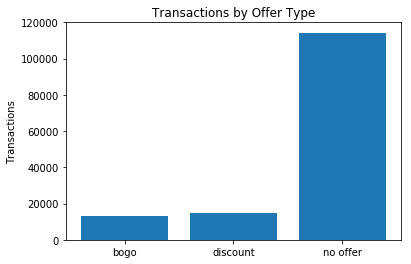

In [57]:
offer_type = graph_1['offer_type']
transactions = graph_1['transaction']

plt.bar(offer_type, transactions, align='center')
plt.ylabel('Transactions')
plt.title('Transactions by Offer Type');

Looking at the number of transactions by offer

In [58]:
graph_2 = df_master.query('transaction == 1')
graph_2 = graph_2[['offer', 'transaction']].groupby(['offer']).sum().reset_index()
graph_2

,offer,transaction
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3516.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5224.0
2,2906b810c7d4411798c6938adc9daaa5,4035.0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,3310.0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,4378.0
5,ae264e3637204a6fb9bb56bc8210ddfd,3707.0
6,f19421c1d4aa40978ebb69ca19b0e20d,4266.0
7,fafdcd668e3743c1bb461111dcafc2a4,5616.0
8,no offer,108594.0


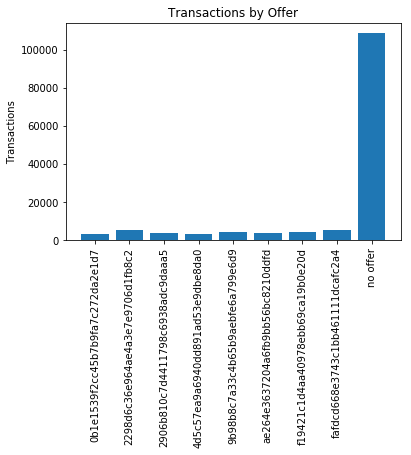

In [59]:
offer = graph_2['offer']
transactions = graph_2['transaction']

plt.bar(offer, transactions, align='center')
plt.xticks(rotation=90)
plt.ylabel('Transactions')
plt.title('Transactions by Offer');

Looking at the distribution of the number of offers a person receives

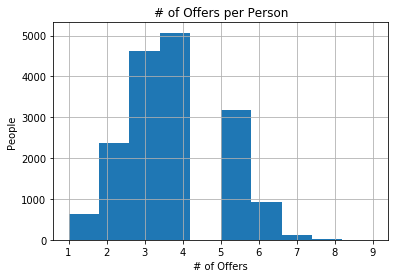

In [60]:
graph_3 = df_master.query('offer != "no offer"')
graph_3 = graph_3[['person', 'offer']].groupby(['person']).count().reset_index()

graph_3.hist()
plt.ylabel('People')
plt.xlabel('# of Offers')
plt.title('# of Offers per Person');


Looking at the number of transactions by offer presented

In [61]:
graph_4 = df_master.query('transaction == 1')
graph_4 = graph_4[['offer_presented', 'transaction']].groupby(['offer_presented']).sum().reset_index()
graph_4

,offer_presented,transaction
0,no offer,108594.0
1,offer,34052.0


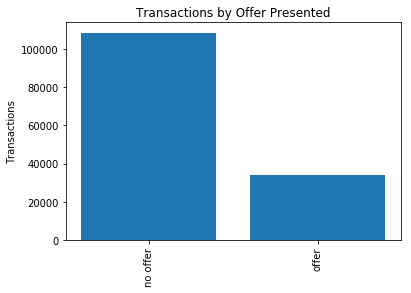

In [62]:
offer_presented = graph_4['offer_presented']
transactions = graph_4['transaction']

plt.bar(offer_presented, transactions, align='center')
plt.xticks(rotation=90)
plt.ylabel('Transactions')
plt.title('Transactions by Offer Presented');

## Analysis:

For this analysis we want to determine which customers have a higher conversion rate when an offer is presented, along with total non offer transactions. We will be looking at customer breakdowns by age, gender, member year, and income.

In [63]:
model_1 = df_master[['age', 'total_offers_received', 'total_offers_transactions', 'total_no_offer_transactions']]
model_1['age_group'] = np.where(model_1.age <= 25, '25 and under', 'none')
model_1['age_group'] = np.where((model_1.age >= 26) & (model_1.age <= 50), '26 to 50', model_1.age_group)
model_1['age_group'] = np.where((model_1.age >= 51) & (model_1.age <= 75), '51 to 75', model_1.age_group)
model_1['age_group'] = np.where(model_1.age >= 76, '76 and older', model_1.age_group)
model_1 = model_1.drop(['age'], axis = 1)
model_1['person_count'] = 1
model_1 = model_1.groupby(['age_group']).sum().reset_index()
model_1['offer_cvr%'] = (model_1['total_offers_transactions'] / model_1['total_offers_received'])*100
model_1.sort_values(by='offer_cvr%', ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,age_group,total_offers_received,total_offers_transactions,total_no_offer_transactions,person_count,offer_cvr%
3,76 and older,57707.0,40002.0,117259.0,15324,69.319147
1,26 to 50,197122.0,119639.0,482820.0,50902,60.692870
2,51 to 75,353788.0,195963.0,725781.0,91691,55.389951
0,25 and under,48019.0,24993.0,136267.0,12576,52.048148


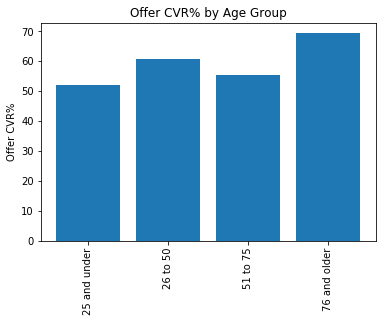

In [64]:
age_group = model_1['age_group']
offer_cvr = model_1['offer_cvr%']

plt.bar(age_group, offer_cvr, align='center')
plt.xticks(rotation=90)
plt.ylabel('Offer CVR%')
plt.title('Offer CVR% by Age Group');

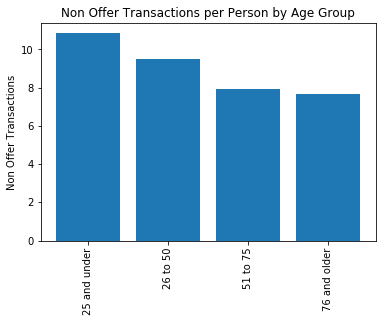

In [65]:
age_group = model_1['age_group']
non_offer_transactions = model_1['total_no_offer_transactions'] / model_1['person_count']

plt.bar(age_group, non_offer_transactions, align='center')
plt.xticks(rotation=90)
plt.ylabel('Non Offer Transactions')
plt.title('Non Offer Transactions per Person by Age Group');

In [66]:
model_2 = df_master[['gender', 'total_offers_received', 'total_offers_transactions', 'total_no_offer_transactions']]
model_2['person_count'] = 1
model_2 = model_2.groupby(['gender']).sum().reset_index()
model_2['offer_cvr%'] = (model_2['total_offers_transactions'] / model_2['total_offers_received'])*100
model_2.sort_values(by='offer_cvr%', ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,gender,total_offers_received,total_offers_transactions,total_no_offer_transactions,person_count,offer_cvr%
2,O,7669.0,5751.0,17290.0,2057,74.990220
0,F,221511.0,164614.0,446391.0,57710,74.314142
1,M,343554.0,195633.0,819590.0,88874,56.943887


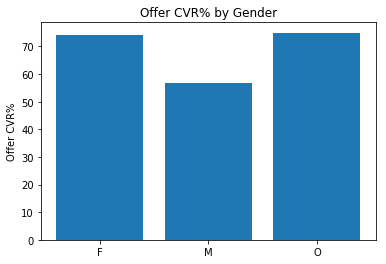

In [67]:
gender = model_2['gender']
offer_cvr = model_2['offer_cvr%']

plt.bar(gender, offer_cvr, align='center')
plt.ylabel('Offer CVR%')
plt.title('Offer CVR% by Gender');

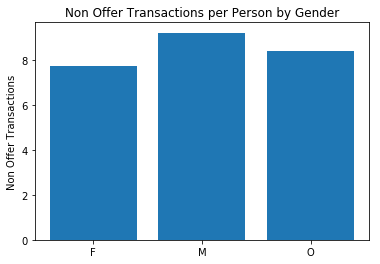

In [68]:
gender = model_2['gender']
non_offer_transactions = model_2['total_no_offer_transactions'] / model_2['person_count']

plt.bar(gender, non_offer_transactions, align='center')
plt.ylabel('Non Offer Transactions')
plt.title('Non Offer Transactions per Person by Gender');

In [69]:
model_3 = df_master[['became_member_year', 'total_offers_received', 'total_offers_transactions', 'total_no_offer_transactions']]
model_3['member_group'] = np.where(model_3.became_member_year <= 2014,  'long term', 'none') 
model_3['member_group'] = np.where((model_3.became_member_year >= 2015) & (model_3.became_member_year <= 2016), 'mid term', model_3.member_group)
model_3['member_group'] = np.where(model_3.became_member_year >= 2017, 'short term', model_3.member_group)
model_3 = model_3.drop('became_member_year', axis=1)
model_3['person_count'] = 1
model_3 = model_3.groupby(['member_group']).sum().reset_index()
model_3['offer_cvr%'] = (model_3['total_offers_transactions'] / model_3['total_offers_received'])*100
model_3.sort_values(by='offer_cvr%', ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,member_group,total_offers_received,total_offers_transactions,total_no_offer_transactions,person_count,offer_cvr%
1,mid term,240349.0,169108.0,616667.0,62220,70.359352
0,long term,53344.0,27251.0,180078.0,13738,51.085408
2,short term,362943.0,184238.0,665382.0,94535,50.762241


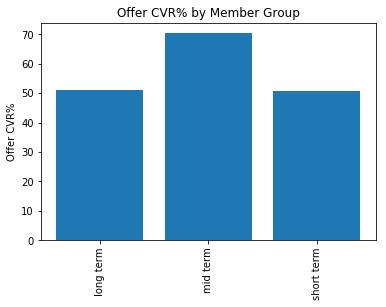

In [70]:
member_group = model_3['member_group']
offer_cvr = model_3['offer_cvr%']

plt.bar(member_group, offer_cvr, align='center')
plt.xticks(rotation=90)
plt.ylabel('Offer CVR%')
plt.title('Offer CVR% by Member Group');

In [71]:
model_3['total_no_offer_transactions'] = np.where((model_3.member_group == 'long term'), model_3.total_no_offer_transactions/6, model_3.total_no_offer_transactions)
model_3['total_no_offer_transactions'] = np.where((model_3.member_group == 'mid term'), model_3.total_no_offer_transactions/4, model_3.total_no_offer_transactions)
model_3['total_no_offer_transactions'] = np.where((model_3.member_group == 'short term'), model_3.total_no_offer_transactions/2, model_3.total_no_offer_transactions)

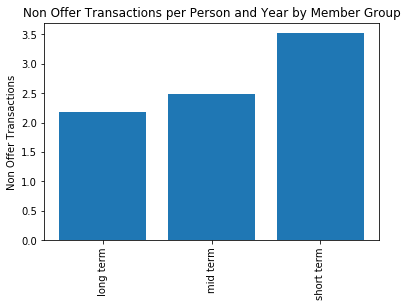

In [72]:
member_group = model_3['member_group']
non_offer_transactions = model_3['total_no_offer_transactions'] / model_3['person_count']

plt.bar(member_group, non_offer_transactions, align='center')
plt.xticks(rotation=90)
plt.ylabel('Non Offer Transactions')
plt.title('Non Offer Transactions per Person and Year by Member Group');

In [73]:
model_4 = df_master[['income', 'total_offers_received', 'total_offers_transactions','total_no_offer_transactions']]
model_4['income_group'] = np.where(model_4.income <= 50000, 'low', 'none')
model_4['income_group'] = np.where((model_4.income >= 50001) & (model_4.income <= 80000), 'mid', model_4.income_group)
model_4['income_group'] = np.where(model_4.income >= 80001, 'high', model_4.income_group)
model_4 = model_4.drop(['income'], axis = 1)
model_4['person_count'] = 1
model_4 = model_4.groupby(['income_group']).sum().reset_index()
model_4['offer_cvr%'] = (model_4['total_offers_transactions'] / model_4['total_offers_received'])*100
model_4.sort_values(by='offer_cvr%', ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,income_group,total_offers_received,total_offers_transactions,total_no_offer_transactions,person_count,offer_cvr%
0,high,102338.0,83765.0,128472.0,26590,81.851316
2,mid,364887.0,200670.0,812097.0,94840,54.995108
1,low,189411.0,96162.0,521558.0,49063,50.768963


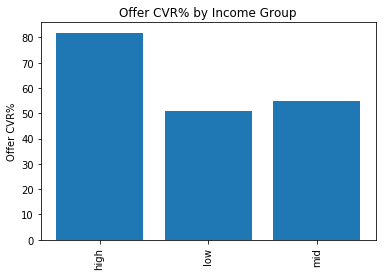

In [74]:
income_group = model_4['income_group']
offer_cvr = model_4['offer_cvr%']

plt.bar(income_group, offer_cvr, align='center')
plt.xticks(rotation=90)
plt.ylabel('Offer CVR%')
plt.title('Offer CVR% by Income Group');

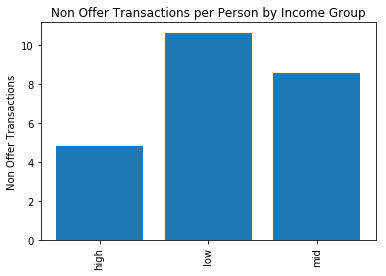

In [75]:
income_group = model_4['income_group']
non_offer_transactions = model_4['total_no_offer_transactions'] / model_4['person_count']

plt.bar(income_group, non_offer_transactions, align='center')
plt.xticks(rotation=90)
plt.ylabel('Non Offer Transactions')
plt.title('Non Offer Transactions per Person by Income Group');

## Discussion:

##### Overview:
In this analysis, we were tasked with finding out what customers are more likely to respond to offers. This analysis also looked at which customers were most likley to purchase without an offer presented. Below is what we found from the analysis performed above.

##### Age:
Customers that are 76 years of age or older have the conversion rate when an offer is presented at 69%. Customers in this age group also have the lowest amount of non offer transactions per person, which is just below 8. Customers that are 25 years of age or younger have the worst offer conversion rate at 52% and also have the highest non offer transactions per person which is just above 10.

##### Gender:
Customers that identify as Other or Female for gender have the highest offer conversion rate at around 75%, and the lowest non offer transaction per person at just below 8. Male customers have the lowest offer conversion rate at 56%, and also have the highest non offer transactions per person at just above 9.

##### Member year:
Customers that are condersidered to be mid term memeber (has been a member for 3 to 4 years) have the highest offer conversion rate at 70%. Customers that are either short term or long term members have the lowest offer conversion rate around 51%. Customers that are considered short term members (has been a member for two years or less) have the highest non offer transactions per person at around 3.5.

##### Income:
Customers in the high income group (greater than 80,000) have the highest offer conversion rate at about 82%. Low income customers (50,000 or less) have the lowest offer conversion rate at about 51%, however they have the largest non offer purchases at just above 10.

##### Reflection:
One thing that was challenging during this analysis was figuring out what to when informational offers were sent to customers. The reason being is that there were no informational offers that had a completed offer tied to it, which I believed was due to not being able to track as there was not a reward. It would be interesting to look at if we customers were more likely to purchase if they recieved an infomation in a certain period of time versus if they were not to recieve an offer. In the future, it would be best to figure out a soltion to track information offers, as the data will be more concerte versus it be a directional analysis.